<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/Test_API_VNQuant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thử nghiệm thư viện vnquant để đồng bộ dữ liệu và xây dựng mô hình dự đoán giá chứng khoán

Model sử dụng tensorflow: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [16]:
!pip install git+https://github.com/phamdinhkhanh/vnquant

  Cloning https://github.com/phamdinhkhanh/vnquant to /tmp/pip-req-build-8dvqxr1s
  Running command git clone -q https://github.com/phamdinhkhanh/vnquant /tmp/pip-req-build-8dvqxr1s
     |████████████████████████████████| 6.3MB 5.3MB/s 
  Created wheel for vnquant: filename=vnquant-0.0.2-cp37-none-any.whl size=9759 sha256=e8e500318f7cfb3ec5da79be3660e23b681f8e93e11a327c88460a9ab88fd2db
  Stored in directory: /tmp/pip-ephem-wheel-cache-8kz8jky9/wheels/70/f7/51/ab84791f03861a32e07cb59321d8911fb994eee39e08f2b77b
  Created wheel for pypandoc: filename=pypandoc-1.5-cp37-none-any.whl size=17036 sha256=1d5c435e8d9b8436b2e4392519ff661d8ea96bea3e594bbeb9b28841bca232bb
  Stored in directory: /root/.cache/pip/wheels/bb/7d/d6/2f9af55e800d37e42e546106bcbd36a86e24e725e303d17e04
Successfully built vnquant pypandoc
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [83]:
import vnquant.DataLoader as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [29]:
loader = web.DataLoader('VND', '2020-02-02','2021-04-02', data_source='VND')
data = loader.download()
data.head()

2021-05-29 16:48:41,765 : INFO : data VND from 2020-02-02 to 2021-04-02 have already cloned!


Attributes,high,low,open,close,avg,volume
Symbols,VND,VND,VND,VND,VND,VND
date,,,,,,
2020-02-03,14.55,13.70,14.55,14.00,13.88,854260.0
2020-02-04,14.00,13.35,14.00,14.00,13.66,617580.0
2020-02-05,14.10,13.70,13.90,14.10,13.93,104530.0
2020-02-06,14.20,13.35,13.35,14.10,13.86,210290.0
2020-02-07,14.20,13.80,14.00,14.05,14.00,158540.0


In [45]:
data.columns = ['high', 'low', 'open', 'close', 'avg', 'volumne']

In [63]:
data['stdev'] = data[['high', 'low', 'open', 'close']].apply(lambda x: np.std(x), axis = 1)
data.head()

,high,low,open,close,avg,volumne,stdev
date,,,,,,,
2020-02-03,14.55,13.70,14.55,14.00,13.88,854260.0,0.365718
2020-02-04,14.00,13.35,14.00,14.00,13.66,617580.0,0.281458
2020-02-05,14.10,13.70,13.90,14.10,13.93,104530.0,0.165831
2020-02-06,14.20,13.35,13.35,14.10,13.86,210290.0,0.401559
2020-02-07,14.20,13.80,14.00,14.05,14.00,158540.0,0.143069


TỰ WINDOWING

In [93]:
rnum = data.shape[0]

In [112]:
split = int(rnum*0.7)
train_df = data[['close', 'volumne', 'stdev']].iloc[:split]
valid_df = data[['close', 'volumne', 'stdev']].iloc[split:]

In [102]:
x1 = data[0:30].mean()
x2 = data[0:15].mean()

In [110]:
(data.iloc[20,:] - data.iloc[2,:])/data.iloc[2,:]

high      -0.042553
low       -0.032847
open      -0.043165
close     -0.042553
avg       -0.036612
volumne    1.037884
stdev     -0.313275
dtype: float64

In [115]:
x1.index

Index(['high', 'low', 'open', 'close', 'avg', 'volumne', 'stdev'], dtype='object')

In [105]:
pd.concat([x1, x2])

high           13.965000
low            13.468333
open           13.716667
close          13.883333
avg            13.715000
volumne    518253.000000
stdev           0.218502
high           14.200000
low            13.770000
open           14.006667
close          14.116667
avg            13.959333
volumne    286252.000000
stdev           0.184021
dtype: float64

In [121]:
# Xử dụng dữ liệu trong 60 ngày, dự đoán giá trong 15 ngày tiếp theo
def get_cur_features(data, point_index, cycle):
  start = data.iloc[(point_index - cycle),:]
  end = data.iloc[point_index,:]
  return  (start - end )/end
def get_features(data, point_index, label = 'close' ):
  ft_7d = get_cur_features( data, point_index, 7)
  ft_14d = get_cur_features( data, point_index, 14)
  features = pd.concat([ft_7d, ft_14d])
  features.index = [i+'_7d' for i in ft_7d.index] + [i+'_14d' for i in ft_14d.index]
  return features

# def get_training_dataset(data,):
#   feature = 
#   labels = data[label].iloc[point_index:(point_index+15)]

In [123]:
y1 = get_features(train_df, 70)
y2 = get_features(train_df, 7)

close_7d      -0.126531
volumne_7d    -0.831081
stdev_7d      -0.810168
close_14d     -0.089796
volumne_14d    0.144603
stdev_14d      0.447583
dtype: float64

In [ ]:
pd.concat([y1, y2])

WINDOWING THEO MẪU

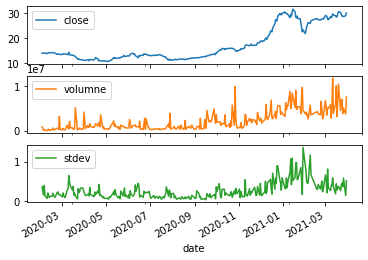

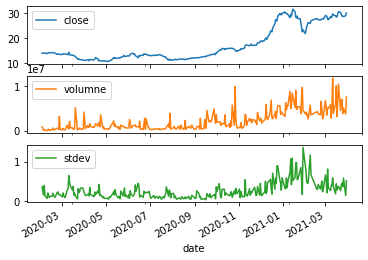

In [66]:
plot_cols = ['close', 'volumne', 'stdev']
plot_features = data[plot_cols]
plot_features.index = data.index
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:480]
plot_features.index = data.index[:480]
_ = plot_features.plot(subplots=True)

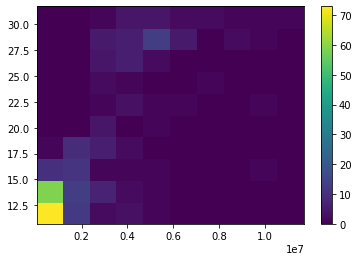

In [72]:
plt.hist2d(data['volumne'], data['close'], )
plt.colorbar()

In [73]:
df = data

In [74]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [75]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


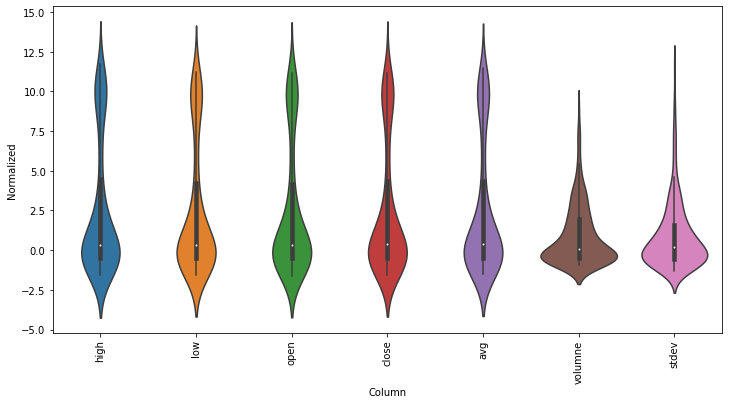

In [78]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [79]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [80]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['close']

In [88]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [89]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [91]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

InvalidArgumentError: ignored